# Simple model for NTK testing

In [1]:
# Uppsetning
using Flux
using Zygote
using MLDatasets
using LinearAlgebra
#  Bætti við ReverseDiff og ForwardDiff til að prufa
using ReverseDiff  # has a tape-feature to save comp. time?
#using ForwardDiff  # Installed along with Zygote

using Plots
using LaTeXStrings

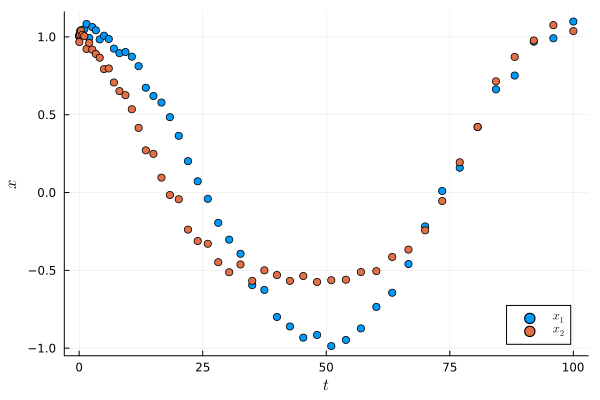

In [2]:
#
# create test data
#
tMax=10
Nt=Int(50)
tVec=collect(((range(start=0.0,stop=tMax,length=Nt).^2))')
ω=0.0631
ϕ=0.0
x1Vec=cos.(ω*tVec .+ ϕ) +  0.1*rand(1,Nt)
δϕ=0.23
A=0.8
B=0.2
x2Vec=A*cos.(ω*tVec .+ ϕ .+ δϕ) + B*cos.(2*(ω*tVec .+ ϕ .+ δϕ)) +  0.1*rand(1,Nt)

scatter(tVec',x1Vec',label=L"$x_1$")
scatter!(tVec',x2Vec',label=L"$x_2$")
plot!(xlabel=L"$t$",ylabel=L"$x$")

In [3]:
#
#  Reproduce simple line fitting
#
actual(x) = 4x .+ 2
x_train, x_test = hcat(0:5...), hcat(6:10...)
y_train, y_test = actual.(x_train), actual.(x_test)

predict = Dense(1 => 1)
loss(model, x, y) = Flux.Losses.mse(model(x),y)
println("loss before =",loss(predict, x_train, y_train))

opt = Descent()
data = [(x_train, y_train)]
Nepoch=200
for epoch=1:Nepoch
    Flux.train!(loss, predict, data, opt)
end

println("loss after =",loss(predict, x_train, y_train))

loss before =214.88606
loss after =0.0062808716


loss before =117.16769
loss after =9.8484e-8


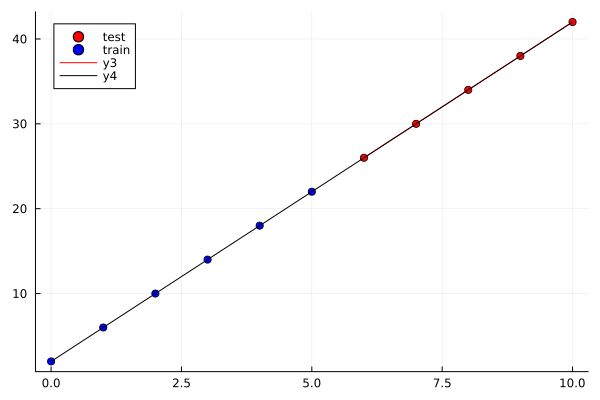

In [4]:
#
#  Reproduce simple line fitting via more advanced code
#
predict = Dense(1 => 1)

println("loss before =",loss(predict, x_train, y_train))

loss(yM, y) = Flux.Losses.mse(yM,y)

for epoch in 1:400
  Flux.train!(predict, data, opt) do m, x, y
    loss(m(x), y)
  end
end

println("loss after =",loss(predict(x_train), y_train))
scatter(x_test',predict(x_test)',color="red",label="test")
scatter!(x_train',predict(x_train)',color="blue",label="train")
#x_test,predict(x_test)
plot!(x_test',actual(x_test)',color="red")
plot!([x_train x_test]',actual([x_train x_test])',color="black")

loss before =167.82814
loss after =0.0001731011


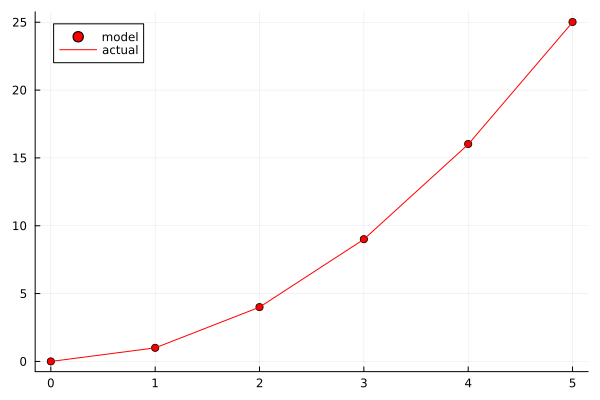

In [5]:
#
#  Reproduce simple line fitting via more advanced code
#
preQuad = Chain(Dense(1 => 10,sigmoid),Dense(10 => 1))

println("loss before =",loss(preQuad, x_train, x_train.^2))

dataQuad = [(x_train, x_train.^2)]
loss(yM, y) = Flux.Losses.mse(yM,y)

for epoch in 1:2000
  Flux.train!(preQuad, dataQuad, opt) do m, x, y
    loss(m(x), y)
  end
end

println("loss after =",loss(preQuad(x_train), x_train.^2))
scatter(x_train',preQuad(x_train)',color="red",label="model")
plot!(x_train',(x_train.^2)',color="red",label="actual")

In [34]:
data1 = [(tVec, x1Vec)]
x1Vec

1×50 Matrix{Float64}:
 1.04634  1.04855  1.07641  0.999821  1.06426  …  0.969582  1.07777  0.885374

In [6]:
# Create simple model

Nhidd=80

model1 = Chain(  Dense(1 => Nhidd,sigmoid),Dense(Nhidd => 1)) # W_2[1x2](W_1[2x2]x[2,1]+b_1[2x1])+b_2[1]

#model1.layers[1].weight[1,1]
#model1.layers[1].bias[3,1]

# Define loss function
loss(yM, y) = Flux.Losses.mse(yM,y)

opt_state = Flux.setup(Adam(0.00003), model1)
opt_state = Flux.setup(Descent(0.0005), model1)
opt = Descent(0.0)
data1 = [(tVec, x1Vec)]
model1(tVec)
println("loss before=",loss(model1(tVec),x1Vec))

for epoch in 1:500000
    Flux.train!(model1, data1, opt_state) do m, x, y
        loss(m(x), y)
    end
end
println("loss after=",loss(model1(tVec),x1Vec))
#Flux.train!(loss, model1, data1, opt_state)


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 80, σ)   # 160 parameters
│   summary(x) = "1×50 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/mqBbi/src/layers/stateless.jl:60


loss before=0.8965035565945658
loss after=0.014007021365899729


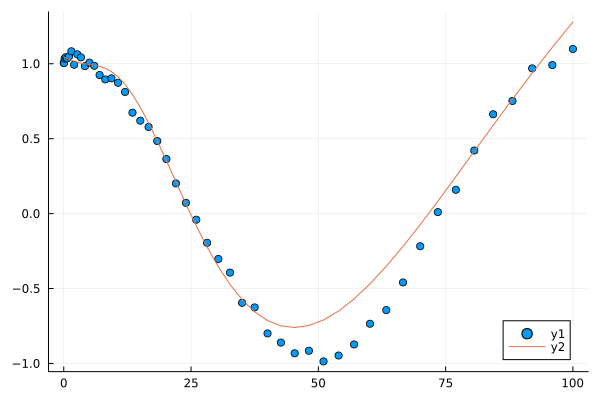

In [7]:
scatter(tVec',x1Vec')
plot!(tVec',model1(tVec)')

In [43]:
# Athugum hvort það séu neikvæð eigingildi
eigval = eigen(K).values
#findall(x-> x<0, eigval)

LoadError: UndefVarError: `K` not defined

Nú prufum við þetta með NN.jl structinu okkar. <br>
Ég hef bara relevant hluta af structinu hér, en hann er á github ásamt öllu hinu.

In [6]:
### Aðferð 2 - með NN.jl

struct NN
    model::Any
    opt         # optimatzation method, so far only GD and ADAM
    lr          # learning rate
end

function load_MNIST()
    """
    Loading the MNIST dataset.
    10 classes of digits from 0 to 9,
    each with 28x28 pixel dimensions.
    X: Grayscale vector, Y: Correct label.
    """

    X_training, Y_training = MNIST(split = :train)[:]
    X_testing, Y_testing = MNIST(split = :test)[:]
    X_training = Flux.flatten(X_training)
    X_testing = Flux.flatten(X_testing)
    Y_training = Flux.onehotbatch(Y_training, 0:9)
    Y_testing = Flux.onehotbatch(Y_testing, 0:9)
    return X_training, Y_training, X_testing, Y_testing
end

function kernel(nn::NN, n=60000)
    """
    This function computes the "Kernel" of a given NN
    """
    x = load_MNIST()[1]     # training data
    K = zeros(n, n)         # Initialize empty Kernel
    model = nn.model
    

    # Calculate all gradients
    gs_raw = []
    for i = 1:n
        xi =  x[:,i] # current datapoint
        push!(gs_raw, Flux.gradient(() -> model(xi)[1],Flux.params(model)))
    end

    # Collect numerical values
    gs = []
    for i = 1:n
        gs_i = []
        for j = 1:length(Flux.params(model))
            push!(gs_i, gs_raw[i][Flux.params(model)[j]])
        end
        push!(gs, gs_i)
    end

    # Evaluate each K[i,j]
    for i = 1:n
        for j = 1:n
            K[i,j] = dot(gs[i], gs[j])
        end
    end

    return K
end

function model_3LS()
    """
    A 3-layer model using 60 nodes in the inner layers.
    Using the sigmoid activation function.
    """

    m_3LS = Chain(
        Dense(28*28, 60, sigmoid), # Input Layer -> Hidden Layer 1
        Dense(60, 60, sigmoid), # Hidden Layer 1 -> Hidden Layer 2
        Dense(60, 10, sigmoid), # Hidden Layer 2 -> Output Layer
        softmax      
    )
    return m_3LS
end

model_3LS (generic function with 1 method)

Athugið að við trainum módelið okkar ekki neitt hér

In [7]:
MODEL  = model_3LS()
OPT    = "ADAM"
LR     = 0.001

myNN = NN(MODEL, OPT, LR)

n = 10
K = kernel(myNN,n) # reiknar fyrir n datapunkta

10×10 Matrix{Float64}:
 0.0111556  0.0110418  0.0109027  …  0.0111046  0.0109061  0.0109173
 0.0110418  0.0112139  0.0109181     0.0110803  0.010892   0.010924
 0.0109027  0.0109181  0.0110516     0.0109909  0.0108542  0.0109238
 0.0109159  0.0109226  0.0108563     0.0109736  0.0108505  0.0108727
 0.0109495  0.0109814  0.0109183     0.011011   0.0109274  0.0109313
 0.0109337  0.0109531  0.0108756  …  0.0110022  0.0108372  0.0108986
 0.0109225  0.0108951  0.0108467     0.010939   0.0109282  0.0108572
 0.0111046  0.0110803  0.0109909     0.0112762  0.0109224  0.0109769
 0.0109061  0.010892   0.0108542     0.0109224  0.0109399  0.0108602
 0.0109173  0.010924   0.0109238     0.0109769  0.0108602  0.0110272

In [8]:
# Athugum hvort það séu neikvæð eigingildi
eigval = eigen(K).values
findall(x-> x<0, eigval)

Int64[]